In [19]:
# Copyright (c) Facebook, Inc. and its affiliates. All rights reserved.

# Render mesh from ShapeNet


- load meshes from an `.obj` file. 
- set up a renderer 
- render the mesh 
- vary the rendering settings such as lighting and camera position
- use the batching features of the pytorch3d API to render the mesh from different viewpoints

## 0. Install and Import modules

If `torch`, `torchvision` and `pytorch3d` are not installed, run the following cell:

In [ ]:
!pip install torch torchvision
!pip install 'git+https://github.com/facebookresearch/pytorch3d.git'

In [1]:
import os
import torch
import matplotlib.pyplot as plt
import tqdm
from skimage.io import imread

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj

# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Textures
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    HardPhongShader,
    TexturedSoftPhongShader,
    HardGouraudShader,
    SoftSilhouetteShader,
    SoftGouraudShader
)

# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))

from utils import image_grid

# Setup
device = torch.device("cuda:1")
torch.cuda.set_device(device)

# Set paths
DATA_DIR = "./data"
shapenet_folder = os.path.join(DATA_DIR, "shapenet_sample")

## 1. Loading Meshes

In [18]:
def convert_bytes(num):
    """
    this function will convert bytes to MB
    """
    
    num /= 1024.0
    num /= 1024.0
    
    return num

In [19]:
def file_size(file_path):
    """
    this function will return the file size
    """
    if os.path.isfile(file_path):
        file_info = os.stat(file_path)
        return convert_bytes(file_info.st_size)

In [20]:
obj_list = []
verts_list = []
faces_list = []
max_vertnums = 0
total_model_size = 0
with open(os.path.join(shapenet_folder, 'pathlist.txt')) as filehandle:
    for line in tqdm.tqdm(filehandle, desc = 'Loading Meshes'):
        obj_folder = line.strip()
        obj_name = os.path.join(shapenet_folder, obj_folder, 'models/model_normalized.obj')
        total_model_size += file_size(obj_name)
        verts, faces, aux = load_obj(obj_name)
        if verts.shape[0] > max_vertnums:
            max_vertnums = verts.shape[0]
        verts_list += [verts]
        faces_list += [faces.verts_idx]

print("Total size of model is {} MB".format(total_model_size))


Loading Meshes: 128it [00:35,  3.57it/s]

Total size of model is 141.173415184021 MB


## 2. Setting the rgb color per vertex for each mesh and batching mesh

In [21]:
#verts_uvs = aux.verts_uvs[None, ...]  # (1, V, 2)
#faces_uvs = faces.textures_idx[None, ...]  # (1, F, 3)
verts_rgb = torch.tensor([[[0.85,0.85,0.85]]])
verts_rgb = verts_rgb.expand(len(verts_list), max_vertnums, 3)

tex = Textures(verts_rgb = verts_rgb)
meshes = Meshes(verts_list, faces_list, textures=tex)
meshes = meshes.to(device)

## 3. Build up a render

In [22]:

# Initialize an OpenGL perspective camera.
# With world coordinates +Y up, +X left and +Z in, the front of the cow is facing the -Z direction. 
# So we move the camera by 180 in the azimuth direction so it is facing the front of the cow. 
R, T = look_at_view_transform(2.7, 0, 180) 
cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. Refer to rasterize_meshes.py for explanations of these parameters. 
raster_settings = RasterizationSettings(
    image_size= 224, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
    bin_size=0
)

# Place a point light in front of the object. As mentioned above, the front of the cow is facing the 
# -z direction. 
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

# Create a phong renderer by composing a rasterizer and a shader. The textured phong shader will 
# interpolate the texture uv coordinates for each vertex, sample from a texture image and 
# apply the Phong lighting model

renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device, 
        cameras=cameras,
        lights=lights
    )
)


'''
print(meshes.textures.verts_rgb_padded().shape)
print(meshes.textures.verts_rgb_padded().view(-1, 3).shape)
'''
 

'\nprint(meshes.textures.verts_rgb_padded().shape)\nprint(meshes.textures.verts_rgb_padded().view(-1, 3).shape)\n'

## 4. Batching view points and render in batch size

In [28]:
# Set batch size - this is the number of model to render in one time
batch_size = 128

# Create a batch of meshes by slicing
meshes = meshes[:batch_size]

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
start.record()
##################################################################################
# Get a batch of viewing angles. 
elev = torch.linspace(30,30,  batch_size)  # [128]
azim = torch.linspace(40, 40,  batch_size)

# All the cameras helper methods support mixed type inputs and broadcasting. So we can 
# view the camera from the same distance and specify dist=1.0 as a float,
# and then specify elevation and azimuth angles for each viewpoint as tensors. 
R, T = look_at_view_transform(dist=1.0, elev=elev, azim=azim)
cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)

# Move the light back in front of the model facing the -z direction.
lights.location = torch.tensor([[0.0, 0.0, -3.0]], device=device)
images = renderer(meshes, cameras=cameras, lights=lights)

#####################
##############################################################
end.record()
torch.cuda.synchronize()
print('Rendering Time Per batch:  %.3f s' % (start.elapsed_time(end)/1000.))
print('Rendered Images size: {}'.format(images.shape))


Rendering Time Per batch:  5.964 s
Rendered Images size: torch.Size([128, 224, 224, 4])


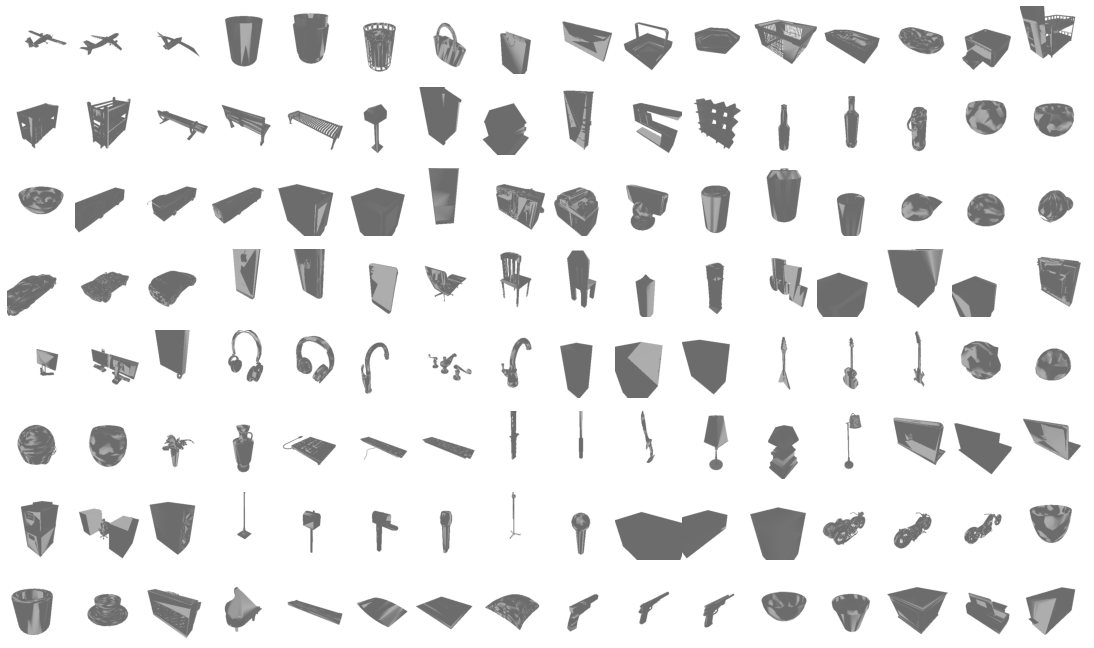

In [29]:
'''
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off");
plt.axis("off");
'''
image_grid(images.cpu().numpy(), rows=8, cols=16, rgb=True)